## Overview

- Kinship verification is an one_to_one classification problem that intended to determine whether or not a pair of facial images are blood relatives of a particular type (e.g., parent-child). This is a classical boolean problem with system responses being either kin and non-kin (i.e., related and unrelated, respectfully). Thus, this task tackles the one-to-one view of automatic kinship recognition.


- To solving this task the pretrained VGGFace framework will be used so the first step is to install it along with the keras_applications pakage that contains the pretrained CNN such as VGG16, VGG19, ResNet50, Xception and much more.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-8hzh69_s
  Running setup.py bdist_wheel for keras-vggface ... done
  Stored in directory: /tmp/pip-ephem-wheel-cache-6vjl4syr/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
    100% |████████████████████████████████| 51kB 2.4MB/s ta 0:00:011


- Importing some useful libraries and packages that will be used along the notebook.

In [3]:
import os
import gc
import cv2
import glob
import threading
import numpy as np 
import pandas as pd 

%matplotlib inline
import matplotlib.pyplot as plt
from random import choice, sample
from collections import defaultdict
from keras_vggface.utils import preprocess_input

Using TensorFlow backend.


## Data Perprocessing

- Counting the total number of images that existing in the kaggle version of the database.

In [4]:
#keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("kaggle/train/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

#list of all members with valid photo
ppl = list(allPhotos.keys())
len(ppl)

2316

- Load the train_relationships file as a dataframe and save it in the kin_df variable.
- Preprocess the data and replace the path of __p1__ and __p2__ columns with a correct path.
- kin_df contains 3598 record each of which have a path for 2 pairs.
- Cleansing the data by comparing the paths of all pairs to the true paths that exists (those are calculated in the pervious step) and thus removing those with incorrect path.

In [5]:
kin_df = pd.read_csv('kaggle/train_relationships.csv')
kin_df.p1 = kin_df.p1.apply( lambda x: 'kaggle/train/'+x )
kin_df.p2 = kin_df.p2.apply( lambda x: 'kaggle/train/'+x )
print(kin_df.shape)
kin_df.head()

(3598, 2)


,p1,p2
0,kaggle/train/F0002/MID1,kaggle/train/F0002/MID3
1,kaggle/train/F0002/MID2,kaggle/train/F0002/MID3
2,kaggle/train/F0005/MID1,kaggle/train/F0005/MID2
3,kaggle/train/F0005/MID3,kaggle/train/F0005/MID2
4,kaggle/train/F0009/MID1,kaggle/train/F0009/MID4


In [6]:
kin_df = kin_df[((kin_df.p1.isin(ppl)) & (kin_df.p2.isin(ppl)))]
len(kin_df)

3362

- Divide the 1000 family into 10 groups each contains 100 families, then calculate the number of occurence of each group in the kin_df dataframe.

- We Found that the groups with max. occurence are F07, F06, F01 respectively.

In [7]:
fam = ['F00', 'F01', 'F02', 'F03', 'F04', 'F05', 'F06', 'F07', 'F08', 'F09']
f = {}
for family in fam:
    f[family] = kin_df.p1.str.count(family).sum() + kin_df.p2.str.count(family).sum()
    
print(f)

{'F00': 520, 'F01': 782, 'F02': 662, 'F03': 604, 'F04': 590, 'F05': 602, 'F06': 786, 'F07': 794, 'F08': 748, 'F09': 592}


- In order to have better results we divide the training into training and validation with 80/20 percentage and to achieve this we exclude the F06 and F09 family groups because they having an accumelative occurence of 689 which is almost 20% of the total number of records(3362).

In [8]:
# 689/3362 = 0.2049
z = ['F06' ,'F09']
kdata = [ (x[0], x[1]) for x in kin_df.values ]
val = []

for f in z:
    temp2 = [x for x in kdata if (f in x[0] or f in x[1])]
    val.extend(temp2)

train = [i for i in kdata if i not in val] 
len(train), len(val), len(kin_df)

(2673, 689, 3362)

In [9]:
data = [ ( x[0], x[1]  ) for x in kin_df.values ]

- Defining some useful functions.

In [10]:
def read_img(path):
    img = cv2.imread(path)
    img = np.array(img).astype(np.float)
    return preprocess_input(img,version=2)

def getImages(p1,p2):
    p1 = read_img(choice(allPhotos[p1]))
    p2 = read_img(choice(allPhotos[p2]))
    return p1,p2

def getMiniBatch(batch_size=16, data=train):
    p1 = []; p2 = []; Y = []
    batch = sample(data, batch_size//2)
    for x in batch:
        _p1, _p2 = getImages(*x)
        p1.append(_p1);p2.append(_p2);Y.append(1)
    while len(Y) < batch_size:
        _p1,_p2 = tuple(np.random.choice(ppl,size=2, replace=False))
        if (_p1,_p2) not in train+val and (_p2,_p1) not in train+val:
            _p1,_p2 = getImages(_p1,_p2)
            p1.append(_p1);p2.append(_p2);Y.append(0) 
    return [np.array(p1),np.array(p2)], np.array(Y)

In [11]:
def initialize_bias(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)
  
def initialize_weights(shape, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

## The Benchmark Model

- For the benchmark model a vgg-face network with vgg16 will be trained and tested, So firstly the model is loaded.

In [12]:
from keras_vggface.vggface import VGGFace

IMG_DIM = (224,224,3)

vggface = VGGFace(model='vgg16', include_top=False)

for layer in vggface.layers[:-3]:
    layer.trainable=True

58916864/58909280 [==============================] - 1s 0us/step


- Feed the pair to the model and calculating the triplet loss function between them.

In [13]:
from keras.layers import Input, Dense, Flatten, Subtract, Dropout, Multiply
from keras.layers import Lambda, Concatenate, GlobalMaxPool2D, GlobalAvgPool2D
from keras.models import Model 
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.2)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

"https://towardsdatascience.com/lossless-triplet-loss-7e932f990b24"

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

- Training the model and save the best checkpoint in 'VGG16_best_checkpoint.h5' file.

In [14]:
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('VGG16_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, samples_per_epoch=200, epochs=100, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

Epoch 1/100
200/200 [==============================] - 497s 2s/step - loss: 1.0772 - acc: 0.5125 - auc: 0.5239 - val_loss: 0.7128 - val_acc: 0.5312 - val_auc: 0.5289
Epoch 2/100
200/200 [==============================] - 486s 2s/step - loss: 0.7194 - acc: 0.5259 - auc: 0.5320 - val_loss: 0.7089 - val_acc: 0.4975 - val_auc: 0.5111
Epoch 3/100
200/200 [==============================] - 486s 2s/step - loss: 0.7033 - acc: 0.5431 - auc: 0.5684 - val_loss: 0.7150 - val_acc: 0.4875 - val_auc: 0.4813
Epoch 4/100
200/200 [==============================] - 486s 2s/step - loss: 0.7074 - acc: 0.5541 - auc: 0.5668 - val_loss: 0.7180 - val_acc: 0.4881 - val_auc: 0.4911
Epoch 5/100
200/200 [==============================] - 485s 2s/step - loss: 0.6969 - acc: 0.5534 - auc: 0.5808 - val_loss: 0.7070 - val_acc: 0.5331 - val_auc: 0.5550
Epoch 6/100
200/200 [==============================] - 486s 2s/step - loss: 0.6882 - acc: 0.5800 - auc: 0.6103 - val_loss: 0.7179 - val_acc: 0.5138 - val_auc: 0.5211
Epoc

Epoch 27/100
200/200 [==============================] - 488s 2s/step - loss: 0.4219 - acc: 0.8059 - auc: 0.8940 - val_loss: 0.9708 - val_acc: 0.5450 - val_auc: 0.6203
Epoch 28/100
200/200 [==============================] - 489s 2s/step - loss: 0.4288 - acc: 0.8031 - auc: 0.8877 - val_loss: 1.0087 - val_acc: 0.5487 - val_auc: 0.6116
Epoch 29/100
199/200 [============================>.] - ETA: 2s - loss: 0.4321 - acc: 0.8053 - auc: 0.8878
Epoch 00029: reducing learning rate to 9.999999974752428e-08.
Epoch 00029: val_auc did not improve
200/200 [==============================] - 489s 2s/step - loss: 0.4324 - acc: 0.8050 - auc: 0.8873 - val_loss: 1.0228 - val_acc: 0.5400 - val_auc: 0.6041
Epoch 30/100
200/200 [==============================] - 490s 2s/step - loss: 0.4160 - acc: 0.8153 - auc: 0.8995 - val_loss: 0.9472 - val_acc: 0.5850 - val_auc: 0.6459
Epoch 31/100
200/200 [==============================] - 489s 2s/step - loss: 0.4279 - acc: 0.8131 - auc: 0.8893 - val_loss: 0.9885 - val_ac

- Results Visualization.

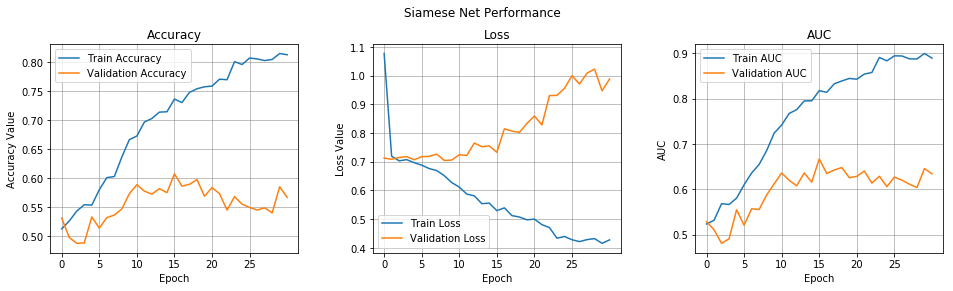

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [16]:
siamese_net.load_weights('VGG16_best_checkpoint.h5')

- After loading the best checkpoint of the model we will run it on the test data by loading the sample_submission file to make the predictions and save the predictions in a 'VGG16_submission.csv' to submit it in the kaggle competition to test it.

In [17]:
submission = pd.read_csv('kaggle/sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: 'kaggle/test/'+x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: 'kaggle/test/'+x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,kaggle/test/face05508.jpg,kaggle/test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,kaggle/test/face05750.jpg,kaggle/test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,kaggle/test/face05820.jpg,kaggle/test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,kaggle/test/face02104.jpg,kaggle/test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,kaggle/test/face02428.jpg,kaggle/test/face05611.jpg


In [18]:
from tqdm import tqdm
probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
    imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
    imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
    prob =  siamese_net.predict( [ imgs1, imgs2 ] )
    probs.append(np.squeeze(prob))
    del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [03:49<00:00, 19.54s/it]


In [19]:
submission.is_related = np.concatenate(probs)
submission.drop( ['p1','p2'],axis=1,inplace=True )
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.559180
1,face05750.jpg-face00898.jpg,0.679362
2,face05820.jpg-face03938.jpg,0.668545
3,face02104.jpg-face01172.jpg,0.822499
4,face02428.jpg-face05611.jpg,0.584599


In [20]:
submission.to_csv('VGG16_submission.csv',index=False)

## ResNet50 Model

Applying almost the same above steps to train, validate and test a ResNet50 network. 

In [21]:
vggface = VGGFace(model='resnet50', include_top=False)

for layer in vggface.layers[:-3]:
    layer.trainable=True

94699520/94694792 [==============================] - 1s 0us/step


In [22]:
left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.2)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

In [23]:
reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('ResNet50_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, samples_per_epoch=200, epochs=100, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

Epoch 1/100
200/200 [==============================] - 304s 2s/step - loss: 0.7351 - acc: 0.5537 - auc: 0.5773 - val_loss: 0.7393 - val_acc: 0.5506 - val_auc: 0.5777
Epoch 2/100
200/200 [==============================] - 295s 1s/step - loss: 0.6596 - acc: 0.6528 - auc: 0.7127 - val_loss: 0.7444 - val_acc: 0.5719 - val_auc: 0.6128
Epoch 3/100
200/200 [==============================] - 294s 1s/step - loss: 0.6231 - acc: 0.6669 - auc: 0.7485 - val_loss: 0.7743 - val_acc: 0.5981 - val_auc: 0.6553
Epoch 4/100
200/200 [==============================] - 295s 1s/step - loss: 0.5671 - acc: 0.7391 - auc: 0.8112 - val_loss: 0.7595 - val_acc: 0.5988 - val_auc: 0.6717
Epoch 5/100
200/200 [==============================] - 294s 1s/step - loss: 0.5519 - acc: 0.7488 - auc: 0.8261 - val_loss: 0.7475 - val_acc: 0.6319 - val_auc: 0.7183
Epoch 6/100
200/200 [==============================] - 295s 1s/step - loss: 0.5308 - acc: 0.7678 - auc: 0.8434 - val_loss: 0.7732 - val_acc: 0.6125 - val_auc: 0.6945
Epoc

- Visalize ResNet50 model results.

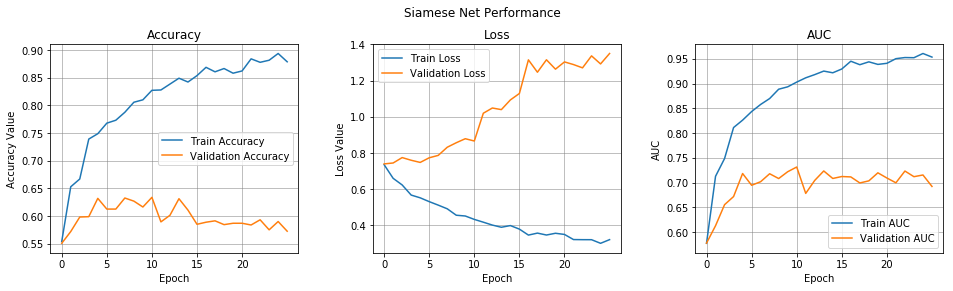

In [24]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [25]:
siamese_net.load_weights('ResNet50_best_checkpoint.h5')

- Test the model on the testing data.

In [26]:
submission = pd.read_csv('kaggle/sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: 'kaggle/test/'+x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: 'kaggle/test/'+x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,kaggle/test/face05508.jpg,kaggle/test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,kaggle/test/face05750.jpg,kaggle/test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,kaggle/test/face05820.jpg,kaggle/test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,kaggle/test/face02104.jpg,kaggle/test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,kaggle/test/face02428.jpg,kaggle/test/face05611.jpg


In [27]:
probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
    imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
    imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
    prob =  siamese_net.predict( [ imgs1, imgs2 ] )
    probs.append(np.squeeze(prob))
    del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [02:36<00:00, 13.07s/it]


In [28]:
submission.is_related = np.concatenate(probs)
submission.drop( ['p1','p2'],axis=1,inplace=True )
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.131412
1,face05750.jpg-face00898.jpg,0.235038
2,face05820.jpg-face03938.jpg,0.881587
3,face02104.jpg-face01172.jpg,0.388984
4,face02428.jpg-face05611.jpg,0.436520


In [29]:
submission.to_csv('ResNet50_submission.csv',index=False)

## SENET50 Model
Applying almost the same above steps to train, validate and test a ResNet50 network.

In [30]:
vggface = VGGFace(model = 'senet50', include_top=False)

for layer in vggface.layers[:-3]:
    layer.trainable=True

104947712/104944616 [==============================] - 3s 0us/step


In [31]:
left_input = Input(IMG_DIM)
right_input = Input(IMG_DIM)

x1 = vggface(left_input)
x2 = vggface(right_input)

x1 = Concatenate(axis=-1)([GlobalMaxPool2D()(x1), GlobalAvgPool2D()(x1)])
x2 = Concatenate(axis=-1)([GlobalMaxPool2D()(x2), GlobalAvgPool2D()(x2)])

fc = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)
x1 = fc(x1)
x2 = fc(x2)

# |h1-h2|
x3 = Lambda(lambda tensors : K.abs(tensors[0] - tensors[1]))([x1, x2])

# |h1-h2|^2
x4 = Lambda(lambda tensor  : K.square(tensor))(x3)

# h1*h2
x5 = Multiply()([x1, x2])

# |h1-h2|^2 + h1*h2
x = Concatenate(axis=-1)([x4,x5])

x = Dense(100,activation='relu',kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias)(x)
x = Dropout(0.2)(x)


prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(x)

siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer = Adam(1e-5)

siamese_net.compile(loss="binary_crossentropy",optimizer=optimizer,metrics=['accuracy',auc])

In [32]:
reducelr = ReduceLROnPlateau(monitor='val_auc', mode='max',patience=6,factor=0.1,verbose=1)

model_checkpoint  = ModelCheckpoint('SENET50_best_checkpoint.h5', save_best_only=True,
                                    save_weights_only=True, monitor='val_auc', mode='max', verbose=1)

early_stopping = EarlyStopping(monitor='val_auc', patience=15, mode='max')

callbacks_list = [reducelr, model_checkpoint, early_stopping]

def Generator(batch_size, data ):
    while True:
        yield getMiniBatch(batch_size=batch_size, data=data)

train_gen = Generator(batch_size=16,data=train)
val_gen = Generator(batch_size=16,data=val)

history = siamese_net.fit_generator( train_gen, samples_per_epoch=200, epochs=100, 
                          validation_data=val_gen, validation_steps=100, use_multiprocessing=True,
                          verbose=1,callbacks=callbacks_list, workers=4)

Epoch 1/100
200/200 [==============================] - 337s 2s/step - loss: 0.7490 - acc: 0.5722 - auc: 0.6037 - val_loss: 0.7473 - val_acc: 0.5619 - val_auc: 0.6017
Epoch 2/100
200/200 [==============================] - 323s 2s/step - loss: 0.6601 - acc: 0.6469 - auc: 0.7191 - val_loss: 0.7689 - val_acc: 0.5850 - val_auc: 0.6436
Epoch 3/100
200/200 [==============================] - 323s 2s/step - loss: 0.6218 - acc: 0.6847 - auc: 0.7639 - val_loss: 0.6990 - val_acc: 0.6400 - val_auc: 0.7183
Epoch 4/100
200/200 [==============================] - 323s 2s/step - loss: 0.5881 - acc: 0.7203 - auc: 0.7949 - val_loss: 0.7390 - val_acc: 0.6038 - val_auc: 0.6866
Epoch 5/100
200/200 [==============================] - 324s 2s/step - loss: 0.5711 - acc: 0.7244 - auc: 0.8048 - val_loss: 0.7673 - val_acc: 0.6162 - val_auc: 0.6878
Epoch 6/100
200/200 [==============================] - 324s 2s/step - loss: 0.5486 - acc: 0.7512 - auc: 0.8303 - val_loss: 0.8330 - val_acc: 0.6275 - val_auc: 0.7228
Epoc

- Visualize the Senet50 model results.

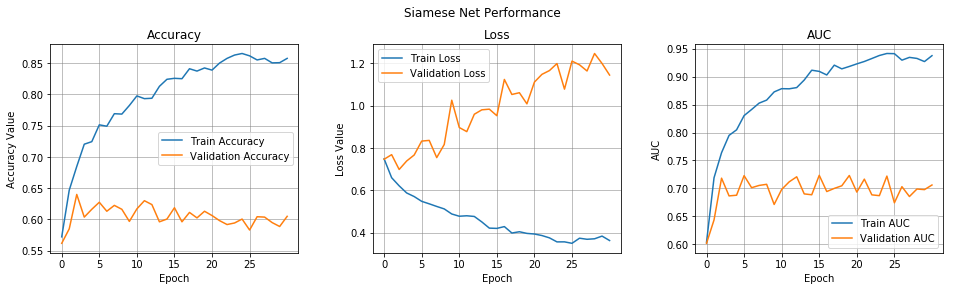

In [33]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Siamese Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = history.epoch

ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('Accuracy Value');ax1.set_xlabel('Epoch');ax1.set_title('Accuracy')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('Loss Value');ax2.set_xlabel('Epoch');ax2.set_title('Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, history.history['auc'], label='Train AUC')
ax3.plot(epoch_list, history.history['val_auc'], label='Validation AUC')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('AUC');ax3.set_xlabel('Epoch');ax3.set_title('AUC')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [34]:
siamese_net.load_weights('SENET50_best_checkpoint.h5')

- Test the model on the testing data.

In [35]:
submission = pd.read_csv('kaggle/sample_submission.csv')
submission['p1'] = submission.img_pair.apply( lambda x: 'kaggle/test/' + x.split('-')[0] )
submission['p2'] = submission.img_pair.apply( lambda x: 'kaggle/test/' + x.split('-')[1] )
print(submission.shape)
submission.head()

(5310, 4)


,img_pair,is_related,p1,p2
0,face05508.jpg-face01210.jpg,0,kaggle/test/face05508.jpg,kaggle/test/face01210.jpg
1,face05750.jpg-face00898.jpg,0,kaggle/test/face05750.jpg,kaggle/test/face00898.jpg
2,face05820.jpg-face03938.jpg,0,kaggle/test/face05820.jpg,kaggle/test/face03938.jpg
3,face02104.jpg-face01172.jpg,0,kaggle/test/face02104.jpg,kaggle/test/face01172.jpg
4,face02428.jpg-face05611.jpg,0,kaggle/test/face02428.jpg,kaggle/test/face05611.jpg


In [36]:
probs = []
for i,j in tqdm([ (0,500),(500,1000),(1000,1500),(1500,2000),(2000,2500),
                 (2500,3000),(3000,3500),(3500,4000),(4000,4500),(4500,5000),(5000,5310) ]):
    imgs1 = np.array( [ read_img(photo) for photo in submission.p1.values[i:j] ] )
    imgs2 = np.array( [ read_img(photo) for photo in submission.p2.values[i:j] ] )
    prob =  siamese_net.predict( [ imgs1, imgs2 ] )
    probs.append(np.squeeze(prob))
    del imgs1,imgs2; gc.collect()

100%|██████████| 11/11 [02:47<00:00, 13.90s/it]


In [37]:
submission.is_related = np.concatenate(probs)
submission.drop(['p1','p2'], axis = 1, inplace = True)
submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.036224
1,face05750.jpg-face00898.jpg,0.802770
2,face05820.jpg-face03938.jpg,0.695187
3,face02104.jpg-face01172.jpg,0.854366
4,face02428.jpg-face05611.jpg,0.444171


In [38]:
submission.to_csv('SENET50_submission.csv', index = False)